In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt

import gc
import pickle as pickle


from sklearn.model_selection import KFold
from itertools import product
import tensorflow as tf

In [3]:
gc.collect()

items           = pd.read_csv('items.csv',usecols=["item_id", "item_category_id"])
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train.csv.gz')
test            = pd.read_csv('test.csv.gz')

In [4]:
sales_train[['day','month', 'year']] = sales_train['date'].str.split('.', expand=True).astype(int)
#sales_train = sales_train[sales_train['year'].isin([2013,2014]) == False]
sales_train = sales_train[sales_train['date_block_num'] > 26]
sales_train = sales_train.set_index('item_id').join(items.set_index('item_id'))
sales_train.reset_index(inplace=True)

In [5]:
max_sales=1000
sums = sales_train.groupby('item_id')['item_cnt_day'].sum().reset_index().rename(columns={"item_cnt_day":"item_total_sales"}).sort_values(by='item_total_sales')

#ids_keep = sums[(sums['item_total_sales'] > 0) & (sums['item_total_sales'] < max_sales)]['item_id'].unique()
ids_keep = sums[(sums['item_total_sales'] > 0)]['item_id'].unique()

In [5]:
train_item_ids = sales_train['item_id'].unique()
#train_item_ids = np.setdiff1d(train_item_ids, ids_reject)
#train_item_ids = ids_keep
train_shop_ids = sales_train['shop_id'].unique()
test_item_ids = test['item_id'].unique()
test_shop_ids = test['shop_id'].unique()
train_blocks = sales_train['date_block_num'].unique()

#all_item_ids = np.unique(np.append(test_item_ids,train_item_ids))
all_item_ids = test_item_ids

#all_shop_ids = np.unique(np.append(train_shop_ids,test_shop_ids))
all_shop_ids = test_shop_ids



In [6]:
combinations = []

for dbn in range(np.min(train_blocks), np.max(train_blocks)+1):
    sales = sales_train[sales_train.date_block_num==dbn]
    #item_ids = np.intersect1d(sales.item_id.unique(), test_item_ids)
    item_ids = all_item_ids
    #dbn_combos = list(product(sales.shop_id.unique(), item_ids, [dbn]))
    dbn_combos = list(product(all_shop_ids, item_ids, [dbn]))
    for combo in dbn_combos:
        combinations.append(combo)
        
all_combos = pd.DataFrame(np.unique(np.vstack([combinations]), axis=0), columns=['shop_id','item_id','date_block_num'])

In [7]:
ys = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"shop_item_cnt_block"})

training = all_combos.merge(ys, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0)


training['shop_item_cnt_block'] = training['shop_item_cnt_block'].clip(0,20).astype('int8')

training = training.set_index('item_id').join(items.set_index('item_id'))
training.reset_index(inplace=True)

for col in ['item_id', 'shop_id', 'item_category_id']:
    training[col] = pd.to_numeric(training[col], downcast='unsigned')

In [8]:
dates = sales_train[['date_block_num', 'month', 'year']].drop_duplicates(['date_block_num', 'month', 'year'])

dates_dict = {}

for index,row in dates.iterrows():
    dates_dict[row['date_block_num']] = {"month": row['month'], "year": row['year']}
    
training['month'] = pd.to_numeric(training['date_block_num'].apply(lambda block: dates_dict[block]['month']), downcast='unsigned')
training['year'] = pd.to_numeric(training['date_block_num'].apply(lambda block: dates_dict[block]['year']), downcast='unsigned')



In [9]:
ys = sales_train.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"item_cnt_block"})

training = training.merge(ys, on=['item_id', 'date_block_num'], how='left').fillna(0)

ys = sales_train.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"shop_cnt_block"})

training = training.merge(ys, on=['shop_id', 'date_block_num'], how='left').fillna(0)


ys = sales_train.groupby(['item_category_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"category_cnt_block"})


training = training.merge(ys, on=['item_category_id', 'date_block_num'], how='left').fillna(0)


ys = sales_train.groupby(['shop_id', 'item_category_id', 'date_block_num'], as_index=False)['item_cnt_day']\
                .sum().rename(columns={"item_cnt_day":"shop_category_cnt_block"})

training = training.merge(ys, on=['shop_id', 'item_category_id', 'date_block_num'], how='left').fillna(0)


In [10]:
training['item_cnt_block_mean'] = training.groupby(['date_block_num'])['item_cnt_block'].transform(np.mean)
training['item_cnt_block_min'] = training.groupby(['date_block_num'])['item_cnt_block'].transform(np.min)
training['item_cnt_block_max'] = training.groupby(['date_block_num'])['item_cnt_block'].transform(np.max)
training['item_cnt_block_std'] = training.groupby(['date_block_num'])['item_cnt_block'].transform(np.std)
training['item_cnt_block_med'] = training.groupby(['date_block_num'])['item_cnt_block'].transform(np.median)

In [11]:
training['shop_cnt_block_mean'] = training.groupby(['date_block_num'])['shop_cnt_block'].transform(np.mean)
training['shop_cnt_block_min'] = training.groupby(['date_block_num'])['shop_cnt_block'].transform(np.min)
training['shop_cnt_block_max'] = training.groupby(['date_block_num'])['shop_cnt_block'].transform(np.max)
training['shop_cnt_block_std'] = training.groupby(['date_block_num'])['shop_cnt_block'].transform(np.std)
training['shop_cnt_block_med'] = training.groupby(['date_block_num'])['shop_cnt_block'].transform(np.median)

In [12]:
training['category_cnt_block_mean'] = training.groupby(['date_block_num'])['category_cnt_block'].transform(np.mean)
training['category_cnt_block_min'] = training.groupby(['date_block_num'])['category_cnt_block'].transform(np.min)
training['category_cnt_block_max'] = training.groupby(['date_block_num'])['category_cnt_block'].transform(np.max)
training['category_cnt_block_std'] = training.groupby(['date_block_num'])['category_cnt_block'].transform(np.std)
training['category_cnt_block_med'] = training.groupby(['date_block_num'])['category_cnt_block'].transform(np.median)

In [13]:
training['shop_category_cnt_block_mean'] = training.groupby(['date_block_num'])['shop_category_cnt_block'].transform(np.mean)
training['shop_category_cnt_block_min'] = training.groupby(['date_block_num'])['shop_category_cnt_block'].transform(np.min)
training['shop_category_cnt_block_max'] = training.groupby(['date_block_num'])['shop_category_cnt_block'].transform(np.max)
training['shop_category_cnt_block_std'] = training.groupby(['date_block_num'])['shop_category_cnt_block'].transform(np.std)
training['shop_category_cnt_block_med'] = training.groupby(['date_block_num'])['shop_category_cnt_block'].transform(np.median)

In [14]:
training['shop_item_cnt_block_mean'] = training.groupby(['date_block_num'])['shop_item_cnt_block'].transform(np.mean)
training['shop_item_cnt_block_min'] = training.groupby(['date_block_num'])['shop_item_cnt_block'].transform(np.min)
training['shop_item_cnt_block_max'] = training.groupby(['date_block_num'])['shop_item_cnt_block'].transform(np.max)
training['shop_item_cnt_block_std'] = training.groupby(['date_block_num'])['shop_item_cnt_block'].transform(np.std)
training['shop_item_cnt_block_med'] = training.groupby(['date_block_num'])['shop_item_cnt_block'].transform(np.median)

In [15]:
#https://maxhalford.github.io/blog/target-encoding-done-the-right-way/
#https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study

from sklearn.model_selection import StratifiedKFold
columns = ["item_id", "shop_id", "item_category_id"]



y_train = training["shop_item_cnt_block"].values
folds = KFold(n_splits = 5, shuffle=True).split(training)

i=1
for in_fold_index, out_of_fold_index in folds:
    print("fold", i)
    #print(np.intersect1d(training.loc[in_fold_index]["shop_id"].unique(), training.loc[out_of_fold_index]["shop_id"].unique()))
    #print(len(in_fold_index))
    for column in columns:
        means = training.iloc[in_fold_index].groupby(column)['shop_item_cnt_block'].mean()
            #x_validation[column + "_mean_target"] = means\
        name = column + '_mean_encoding'
        training.loc[out_of_fold_index,name] = training.loc[out_of_fold_index][column].map(means)
    i+=1

fold 1
fold 2
fold 3
fold 4
fold 5


In [16]:
training.fillna(0,inplace=True)

In [17]:

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
training.sample(10)

,item_id,shop_id,date_block_num,shop_item_cnt_block,item_category_id,month,year,item_cnt_block,shop_cnt_block,category_cnt_block,shop_category_cnt_block,item_cnt_block_mean,item_cnt_block_min,item_cnt_block_max,item_cnt_block_std,item_cnt_block_med,shop_cnt_block_mean,shop_cnt_block_min,shop_cnt_block_max,shop_cnt_block_std,shop_cnt_block_med,category_cnt_block_mean,category_cnt_block_min,category_cnt_block_max,category_cnt_block_std,category_cnt_block_med,shop_category_cnt_block_mean,shop_category_cnt_block_min,shop_category_cnt_block_max,shop_category_cnt_block_std,shop_category_cnt_block_med,shop_item_cnt_block_mean,shop_item_cnt_block_min,shop_item_cnt_block_max,shop_item_cnt_block_std,shop_item_cnt_block_med,item_id_mean_encoding,shop_id_mean_encoding,item_category_id_mean_encoding
539180,7956,57,32,1,6,9,2015,9.0,2266.0,237.0,11.0,11.648627,0.0,3390.0,61.946153,3.0,1719.523810,0.0,6867.0,1596.048841,1230.0,2829.167059,0.0,7107.0,2461.715660,1670.0,66.414052,0.0,1079.0,114.964885,29.0,0.246452,0,20,1.115817,0,0.213675,0.399283,0.625882
5602,83,4,29,0,40,6,2015,0.0,793.0,9304.0,79.0,10.833333,-1.0,3473.0,58.426138,2.0,1430.904762,0.0,6160.0,1194.835848,1058.0,3318.272157,0.0,9304.0,3228.111861,1919.0,74.266709,0.0,1529.0,150.766699,29.0,0.221471,0,20,1.008618,0,0.000000,0.138748,0.196160
1497482,22145,34,27,0,37,4,2015,0.0,424.0,4670.0,38.0,12.535490,-1.0,7300.0,124.515785,2.0,1711.166667,0.0,7341.0,1447.095173,1309.5,4010.790784,0.0,14751.0,4102.264551,2285.0,88.694935,-1.0,2506.0,195.630747,26.0,0.215145,0,20,1.079221,0,0.043290,0.073360,0.179334
1339784,19618,5,32,0,37,9,2015,7.0,1092.0,2989.0,52.0,11.648627,0.0,3390.0,61.946153,3.0,1719.523810,0.0,6867.0,1596.048841,1230.0,2829.167059,0.0,7107.0,2461.715660,1670.0,66.414052,0.0,1079.0,114.964885,29.0,0.246452,0,20,1.115817,0,0.105042,0.176103,0.179534
1496800,22137,10,31,0,40,8,2015,0.0,442.0,8513.0,59.0,11.840196,-1.0,3551.0,57.770225,3.0,1551.500000,0.0,5714.0,1090.984155,1271.0,3253.890392,0.0,8513.0,2995.889840,1788.0,75.921218,0.0,1189.0,128.648912,32.0,0.260037,0,20,1.031644,0,0.000000,0.078812,0.195342
1140210,16153,18,28,0,64,5,2015,13.0,1434.0,906.0,10.0,11.949804,0.0,3768.0,89.593827,2.0,1592.166667,0.0,6327.0,1311.452767,1211.5,3428.631373,0.0,9208.0,3303.055672,1635.0,75.539594,-1.0,2005.0,147.855428,26.0,0.213301,0,20,1.018289,0,0.296460,0.203229,0.160670
33985,687,39,27,0,73,4,2015,18.0,754.0,380.0,1.0,12.535490,-1.0,7300.0,124.515785,2.0,1711.166667,0.0,7341.0,1447.095173,1309.5,4010.790784,0.0,14751.0,4102.264551,2285.0,88.694935,-1.0,2506.0,195.630747,26.0,0.215145,0,20,1.079221,0,0.315315,0.120108,0.316074
1482750,21948,24,30,0,61,7,2015,0.0,1014.0,516.0,0.0,10.808824,-1.0,3347.0,53.842045,3.0,1427.642857,0.0,5987.0,1114.915109,1108.0,3335.517843,0.0,9283.0,3239.632607,1890.0,75.583501,-1.0,1475.0,141.362130,32.0,0.227605,0,20,0.949685,0,0.004292,0.199301,0.071690
854044,12970,56,29,1,55,6,2015,10.0,1566.0,6017.0,147.0,10.833333,-1.0,3473.0,58.426138,2.0,1430.904762,0.0,6160.0,1194.835848,1058.0,3318.272157,0.0,9304.0,3228.111861,1919.0,74.266709,0.0,1529.0,150.766699,29.0,0.221471,0,20,1.008618,0,0.334764,0.217341,0.193790
1045360,15223,42,28,0,63,5,2015,6.0,4343.0,1370.0,75.0,11.949804,0.0,3768.0,89.593827,2.0,1592.166667,0.0,6327.0,1311.452767,1211.5,3428.631373,0.0,9208.0,3303.055672,1635.0,75.539594,-1.0,2005.0,147.855428,26.0,0.213301,0,20,1.018289,0,0.086420,0.570411,0.248845


In [18]:
training.columns.values

array(['item_id', 'shop_id', 'date_block_num', 'shop_item_cnt_block',
       'item_category_id', 'month', 'year', 'item_cnt_block',
       'shop_cnt_block', 'category_cnt_block', 'shop_category_cnt_block',
       'item_cnt_block_mean', 'item_cnt_block_min', 'item_cnt_block_max',
       'item_cnt_block_std', 'item_cnt_block_med', 'shop_cnt_block_mean',
       'shop_cnt_block_min', 'shop_cnt_block_max', 'shop_cnt_block_std',
       'shop_cnt_block_med', 'category_cnt_block_mean',
       'category_cnt_block_min', 'category_cnt_block_max',
       'category_cnt_block_std', 'category_cnt_block_med',
       'shop_category_cnt_block_mean', 'shop_category_cnt_block_min',
       'shop_category_cnt_block_max', 'shop_category_cnt_block_std',
       'shop_category_cnt_block_med', 'shop_item_cnt_block_mean',
       'shop_item_cnt_block_min', 'shop_item_cnt_block_max',
       'shop_item_cnt_block_std', 'shop_item_cnt_block_med',
       'item_id_mean_encoding', 'shop_id_mean_encoding',
       'item_ca

In [20]:
all_features = [
    
    'item_cnt_block',
       'shop_cnt_block', 'category_cnt_block', 'shop_category_cnt_block',
       'item_cnt_block_mean', 'item_cnt_block_min', 'item_cnt_block_max',
       'item_cnt_block_std', 'item_cnt_block_med', 'shop_cnt_block_mean',
       'shop_cnt_block_min', 'shop_cnt_block_max', 'shop_cnt_block_std',
       'shop_cnt_block_med', 'category_cnt_block_mean',
       'category_cnt_block_min', 'category_cnt_block_max',
       'category_cnt_block_std', 'category_cnt_block_med',
       'shop_category_cnt_block_mean', 'shop_category_cnt_block_min',
       'shop_category_cnt_block_max', 'shop_category_cnt_block_std',
       'shop_category_cnt_block_med', 'shop_item_cnt_block_mean',
       'shop_item_cnt_block_min', 'shop_item_cnt_block_max',
       'shop_item_cnt_block_std', 'shop_item_cnt_block_med',
       'item_id_mean_encoding', 'shop_id_mean_encoding',
       'item_category_id_mean_encoding'
    
    
]



features = [
    
     'item_cnt_block',
       'shop_cnt_block', 'category_cnt_block', 'shop_category_cnt_block',
      
    
]

#features = all_features

#features = ['pca0', 'pca1', 'pca2', 'pca3',  'pca4']

In [21]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler 


training[all_features] = StandardScaler().fit_transform(training[all_features])



/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [22]:
training[all_features] = training[all_features].apply(pd.to_numeric, downcast='float')

In [90]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5).fit(training[features])
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

training_pca = pca.transform(training[features])

for i,component in enumerate(pca.explained_variance_ratio_):
    name = 'pca%d' % (i)
    training[name] = np.array(training_pca).T[i]

[0.3478112  0.18928401 0.10767918 0.08343084 0.07857975]
0.8067849771669491


In [23]:
window_size = 6
dbns = sorted(training.date_block_num.unique())

windows = []
for i,_ in enumerate(dbns):
    if (i+window_size) <= len(dbns):
        window = dbns[i:i+window_size]
        windows.append(window)  
 
windows = [list(range(27,34))]

print(windows)



[[27, 28, 29, 30, 31, 32, 33]]


In [24]:
features

['item_cnt_block',
 'shop_cnt_block',
 'category_cnt_block',
 'shop_category_cnt_block']

In [25]:

  
        

import multiprocessing as mp

import importlib
import build_sample
importlib.reload(build_sample)

from build_sample import build_sample_f

if __name__ ==  '__main__':
    pool = mp.Pool(mp.cpu_count())
    res = [pool.apply_async(build_sample_f,args=[window, training, features]) for window in windows]
    pool.close()
    pool.join()
    
lstm_data = []
lstm_y = []

for result in res:
    for idx, sample in enumerate(result.get()[0]):
        lstm_data.append(sample)
        lstm_y.append(result.get()[1][idx])

[27, 28, 29, 30, 31, 32, 33]


In [26]:
small_data = np.array(lstm_data)
small_y = np.array(lstm_y)

In [31]:
print(len(lstm_y))

print(len([y for y in lstm_y if y == 0]))

zeros_indices = {}
for idx,y in enumerate(lstm_y):
    
    if y == 0:
        zeros_indices[idx] = True

632988
601517


In [32]:
lstm_data_no_zeros = []
lstm_y_no_zeros = []
for idx,sample in enumerate(lstm_data):
    if idx not in zeros_indices:
        lstm_data_no_zeros.append(sample)
        lstm_y_no_zeros.append(lstm_y[idx])

In [33]:
lstm_zeros = []
for idx,y in enumerate(lstm_y):
    if idx in zeros_indices:
        lstm_zeros.append(idx)

In [34]:
len(lstm_data_no_zeros)

31471

In [35]:
#print(len(lstm_data_no_zeros))

for zero_idx in np.random.choice(lstm_zeros,30000,replace=False):
    lstm_data_no_zeros.append(lstm_data[zero_idx])
    lstm_y_no_zeros.append(lstm_y[zero_idx])

In [36]:
small_data = np.array(lstm_data_no_zeros)
small_y = np.array(lstm_y_no_zeros)

In [27]:
from sklearn.model_selection import train_test_split

train_data, val_data, y_train, y_val = train_test_split(small_data, small_y, test_size=0.1, random_state=42)

In [ ]:
np.array(lstm_data).shape

In [28]:
train_data.shape

(192780, 6, 4)

In [38]:
y_train.shape

(55323, 1)

In [ ]:
np.mean(lstm_y_no_zeros)

In [ ]:
lstm_y_no_zeros

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 3)                 96        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 4         
Total params: 100
Trainable params: 100
Non-trainable params: 0
_________________________________________________________________
Train on 192780 samples, validate on 21420 samples
Epoch 1/100
192780/192780 [==============================] - 84s 435us/step - loss: 1.0965 - mean_squared_error: 1.0543 - val_loss: 1.0279 - val_mean_squared_error: 1.0077
Epoch 2/100
192780/192780 [==============================] - 83s 429us/step - loss: 1.0363 - mean_squared_error: 1.0180 - val_loss: 0.9983 - val_mean_squared_error: 0.9799
Epoch 3/100
192780/192780 [==============================] - 84s 435us/step - loss: 1.0158 - mean_squared_error: 0.9976 - val_loss: 0.9881 - val_

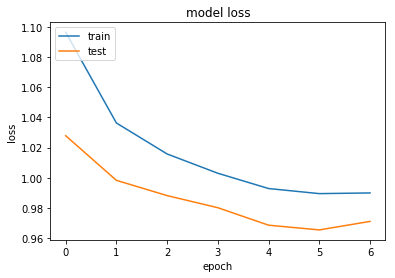

best rmse val: 0.9746956746674342


In [64]:
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Flatten,GRU,CuDNNGRU,CuDNNLSTM,Bidirectional
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.regularizers import L1L2


dropout=0.2

my_model = Sequential()
reg = L1L2(l1=0.01,l2=0.01)
my_model.add(LSTM(use_bias = True,unit_forget_bias=True,units = 3, kernel_regularizer=reg, dropout=dropout,recurrent_dropout=dropout,input_shape = (small_data.shape[1],len(features))))

my_model.add(Dense(1))

my_model.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
my_model.summary()


callbacks = [
    EarlyStopping(monitor='val_loss', patience=0, verbose=0)
]

history = my_model.fit(train_data, y_train, batch_size=32, epochs=100,
                      validation_data=(val_data,y_val), callbacks=callbacks
                      )


import matplotlib.pyplot as plt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

import math
print("best rmse val:", math.sqrt(my_model.history.history['val_mean_squared_error'][-1]))

In [34]:
training_test = training[(training['shop_id'].isin(test['shop_id'].unique()))\
                         & (training['item_id'].isin(test['item_id'].unique())) \
                        & (training['date_block_num'].isin(windows[0]))]

In [35]:
a = list(range(0, 235620, 21420))
b = list(range(21420, 257040, 21420))
intervals = list(zip(a,b))[:-1]
intervals

[(0, 21420),
 (21420, 42840),
 (42840, 64260),
 (64260, 85680),
 (85680, 107100),
 (107100, 128520),
 (128520, 149940),
 (149940, 171360),
 (171360, 192780),
 (192780, 214200)]

In [36]:

import multiprocessing as mp

import importlib
import build_test
importlib.reload(build_test)

window_size = len(windows[0])

from build_test import build_test_f

if __name__ ==  '__main__':
    pool = mp.Pool(mp.cpu_count())
    res = [pool.apply_async(build_test_f,args=[interval, test, training_test, features, window_size]) for interval in intervals]
    pool.close()
    pool.join()

(0, 21420)
(21420, 42840)
(42840, 64260)
(64260, 85680)
(85680, 107100)
(107100, 128520)
(128520, 149940)
(149940, 171360)
(171360, 192780)
(192780, 214200)


In [37]:
test_lstm_data = []

for interval in intervals:
    for re in res:
        if interval in re.get():
            for sample in re.get()[interval]:
                test_lstm_data.append(sample)

In [38]:
test_lstm_data = np.array(test_lstm_data)

In [39]:
test_lstm_data.shape

(214200, 6, 4)

In [58]:
preds = my_model.predict(np.array(test_lstm_data),batch_size=len(test_lstm_data))
preds.clip(0,20,out=preds)

array([[0.6439266 ],
       [0.15946472],
       [0.8257191 ],
       ...,
       [0.15322077],
       [0.15034592],
       [0.09652233]], dtype=float32)

In [59]:

print(np.mean(preds))
print(np.max(preds))

submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds

submission.to_csv('submission.csv', index=False)

0.25486293
10.4675665


In [57]:
bestpreds = pd.read_csv('submissionbest.csv')['item_cnt_month']
print(np.mean(bestpreds))
print(np.max(bestpreds))

0.3542884257097005
16.49019305497366


In [ ]:
lr_preds = pd.read_csv('lr110.csv')['item_cnt_month']
lg_preds = pd.read_csv('lg110.csv')['item_cnt_month']
#cb_preds = pd.read_csv('cb102.csv')['item_cnt_month']


#preds = np.mean(np.array([lr_preds, lg_preds]),axis=0)

preds = (lg_preds * 0.50) + (lr_preds * 0.50)